# With dynamic dt

Process:

- Coarse Search (Fast): Use a large, efficient dt to quickly scan through the orbit. It doesn't look for the exact transit time, but rather for the time interval during which a transit must have occurred.

- Fine-Grained Refinement (Accurate): Once that small time window is found, and only then, does it "zoom in" and use a much smaller, high-precision timestep (refinement_dt) to find the exact moment of the transit within that window.

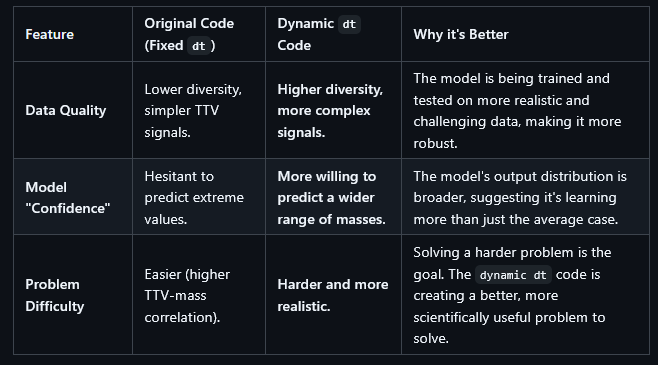


Starting data generation...
  Running simulation 10/500...
  Running simulation 20/500...
  Running simulation 30/500...
  Running simulation 40/500...
  Running simulation 50/500...
  Running simulation 60/500...
  Running simulation 70/500...
  Running simulation 80/500...
  Running simulation 90/500...
  Running simulation 100/500...
  Running simulation 110/500...
  Running simulation 120/500...
  Running simulation 130/500...
  Running simulation 140/500...
  Running simulation 150/500...
  Running simulation 160/500...
  Running simulation 170/500...
  Running simulation 180/500...
  Running simulation 190/500...
  Running simulation 200/500...
  Running simulation 210/500...
  Running simulation 220/500...
  Running simulation 230/500...
  Running simulation 240/500...
  Running simulation 250/500...
  Running simulation 260/500...
  Running simulation 270/500...
  Running simulation 280/500...
  Running simulation 290/500...
  Running simulation 300/500...
  Running simulation 

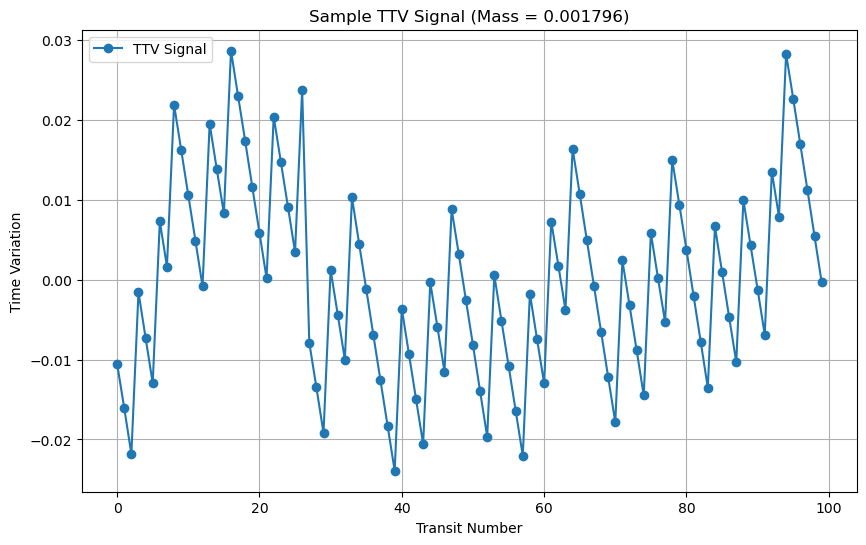

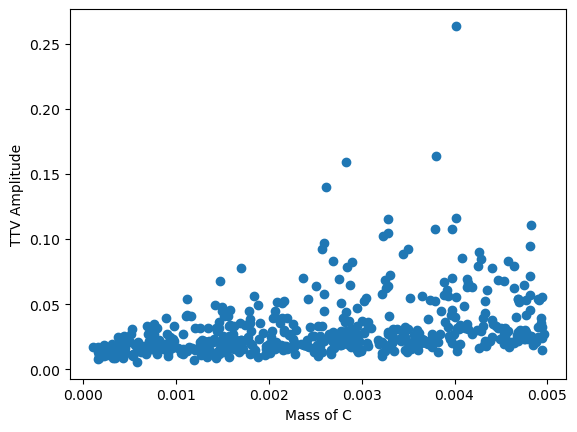


Starting model training...
Epoch [10/200], Train Loss: 0.028465, Val Loss: 0.260735
Epoch [20/200], Train Loss: 0.011257, Val Loss: 0.144565
Epoch [30/200], Train Loss: 0.007875, Val Loss: 0.128296
Epoch [40/200], Train Loss: 0.005013, Val Loss: 0.121236
Epoch [50/200], Train Loss: 0.004843, Val Loss: 0.117031
Epoch [60/200], Train Loss: 0.003824, Val Loss: 0.118846
Epoch [70/200], Train Loss: 0.003216, Val Loss: 0.118719
Early stopping at epoch 77
Training complete.

--- Testing the trained model ---
Test MSE: 0.04260158
Test MAE: 0.11997876
  Actual: 2.966270, Predicted: 3.014727
  Actual: 2.973245, Predicted: 2.921365
  Actual: 2.398748, Predicted: 2.469710
  Actual: 3.166742, Predicted: 3.063087
  Actual: 3.024277, Predicted: 2.919281


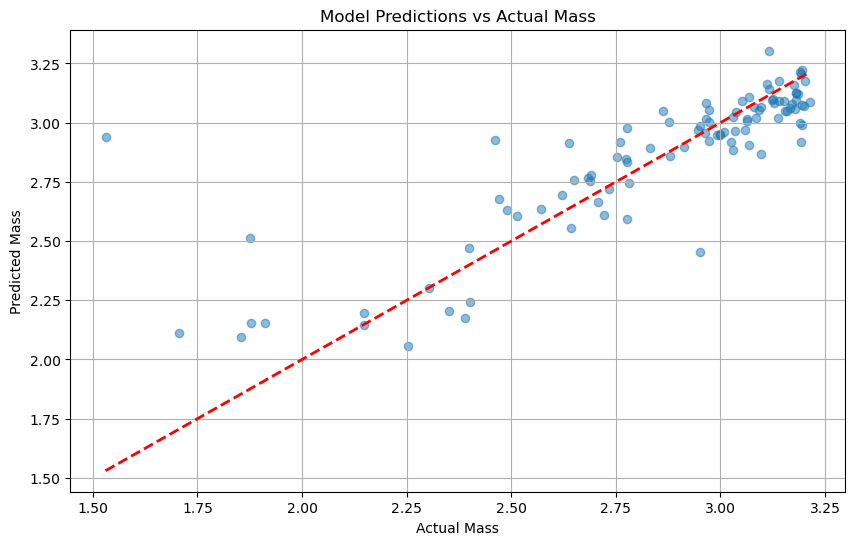

Standard Deviation of predictions: 0.29982385
Label StdDev: 1.086935053494701, Prediction StdDev: 0.8632469773292542
Physical Correlation (TTV Strength vs Mass): 0.3490


In [ ]:
from scipy.stats import pearsonr
import numpy as np
import rebound
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#-----------------------------------------------------------------------------
# Detect Transits Function
#-----------------------------------------------------------------------------

def detect_transits(sim, integration_time, dt, max_transits, planet_index, star_index=0):
    """
    Detects transit times with a high-precision refinement step.
    A transit occurs when the planet's y-coordinate crosses the y=0 plane in front of the star.
    """
    transit_times = []
    star = sim.particles[star_index]
    planet = sim.particles[planet_index]
    # Get initial position relative to star
    prev_y = planet.y - star.y                  # Initial relative y-position
    n_steps = int(integration_time / dt)        # Calculate how many large steps to take
    
    for _ in range(n_steps):
        if len(transit_times) >= max_transits:  
            break
            
        time_before_step = sim.t                
        sim.integrate(time_before_step + dt)    # Integrate forward by dt, Taking one big, fast step
        curr_y = planet.y - star.y              # Update Current relative y-position
        
        # Check if a transit happened during this big step
        if prev_y * curr_y < 0 and (planet.x - star.x) > 0:         # Transit condition 
            temp_sim = sim.copy()                                   # Create an independent copy of the simulation state
            temp_sim.t = time_before_step                           # Rewind the copy to the start of the interval
            
            refinement_dt = dt / 50.0                        # Define a much smaller, high-precision timestep to refine
            refine_steps = int(dt / refinement_dt) + 1       # Number of refinement steps
            y1 = prev_y                                      # Start of the refinement window's position
            t1 = time_before_step                            # Start of the refinement window's time
            precise_time = time_before_step + dt / 2.0       # Fallback to some midpoint if we somehow dont find a transit
            
            for _ in range(refine_steps):
                t2 = temp_sim.t + refinement_dt              # Move forward by the small refinement step
                temp_sim.integrate(t2)                       # Integrating to the that new time
                p_temp, s_temp = temp_sim.particles[planet_index], temp_sim.particles[star_index]
                y2 = p_temp.y - s_temp.y                     # Updated relative y-position
                
                if y1 * y2 < 0: # Crossing detected in refinement       
                    # This is a much tighter bracket. Use linear interpolation here.
                    denominator = y2 - y1
                    if abs(denominator) > 1e-9: # Avoid division by zero
                        weight = -y1 / denominator
                        precise_time = t1 + weight * refinement_dt
                    break # Exit refinement loop once crossing is found
                y1, t1 = y2, t2

            transit_times.append(precise_time)
        prev_y = curr_y
        
    return np.array(transit_times)

#-----------------------------------------------------------------------------
# Calculate TTVs Function
#-----------------------------------------------------------------------------

def calculate_ttvs(transit_times_perturbed, transit_times_unperturbed):
    """
    Calculates TTVs by subtracting the unperturbed transit times from the perturbed ones.
    """
    min_len = min(len(transit_times_perturbed), len(transit_times_unperturbed))
    if min_len == 0:
        return np.array([])
    ttvs = transit_times_perturbed[:min_len] - transit_times_unperturbed[:min_len]
    return ttvs

#-----------------------------------------------------------------------------
# Detrend TTVs Function
#-----------------------------------------------------------------------------

def detrend_ttv(ttv_data):
    """Removes the linear trend from a single TTV array."""
    N = len(ttv_data)
    # Create an array of transit numbers (0, 1, 2, ..., N-1)
    transit_numbers = np.arange(N)
    # Fit a straight line (polynomial of degree 1)
    # P[0] is the slope, P[1] is the intercept
    P = np.polyfit(transit_numbers, ttv_data, 1)
    # Calculate the linear trend line
    trend = P[0] * transit_numbers + P[1]
    # Subtract the trend
    return ttv_data - trend


#============================================================================
# --- PHASE 1: GENERATE TRAINING DATA --- 
#============================================================================

def generate_simulation_data(num_simulations, max_transits, base_dt, integration_time=1000):
    """
    Generates training data by running N-body simulations.
    Dynamically scales the integration timestep `dt` for each simulation based on
    the inner planet's period to ensure accuracy.
    """
    print("Starting data generation...")
    all_features = []
    all_masses = []
    all_periods_c= []
    failed_sims = 0
    
    for i in range(num_simulations):
        if (i + 1) % 10 == 0:
            print(f"  Running simulation {i+1}/{num_simulations}...")
        try:
            # --- Simulation parameters ---
            m_b = np.random.uniform(0.5e-4, 1.5e-4)   
            P_b = np.random.uniform(1.0, 2.0)
            e_b = np.random.uniform(0.0, 0.2)
            
            # 1. COMPUTE DYNAMIC dt and WARN if base_dt is too coarse
            recommended_dt = P_b / 50.0
            if base_dt > recommended_dt * 1.5: # Warn if user dt is >50% larger than ideal
                print(f"  Warning: base_dt ({base_dt:.4f}) is large for P_b={P_b:.2f}. "
                      f"Consider a smaller base_dt. Using {recommended_dt:.4f}.")
            
            # Use the smaller of the user-provided dt and the recommended dt
            sim_dt = min(base_dt, recommended_dt)

            # --- System setup ---
            ratio = 2.1 
            m_c = np.random.uniform(1e-4, 5e-3)            
            P_c = P_b * ratio
            e_c = np.random.uniform(0.0, 0.2)
            
            # --- Unperturbed Reference ---
            sim_unperturbed = rebound.Simulation()
            sim_unperturbed.integrator = "whfast"
            sim_unperturbed.dt = sim_dt
            sim_unperturbed.add(m=1.0)
            sim_unperturbed.add(m=m_b, P=P_b, e=e_b)
            sim_unperturbed.move_to_com()
            # Pass the dynamically calculated dt to the transit detector
            unperturbed_transits = detect_transits(sim_unperturbed, integration_time, sim_dt, max_transits, 1)

            # --- Perturbed System ---
            sim_perturbed = rebound.Simulation()
            sim_perturbed.integrator = "whfast"
            sim_perturbed.dt = sim_dt
            sim_perturbed.add(m=1.0)
            sim_perturbed.add(m=m_b, P=P_b, e=e_b)
            sim_perturbed.add(m=m_c, P=P_c, e=e_c)
            sim_perturbed.move_to_com()
            # Pass the dynamically calculated dt here as well
            perturbed_transits = detect_transits(sim_perturbed, integration_time, sim_dt, max_transits, 1)
            
            # --- TTV Calculation ---
            if len(unperturbed_transits) >= max_transits and len(perturbed_transits) >= max_transits:
                ttv_vec = (perturbed_transits[:max_transits] - unperturbed_transits[:max_transits])
                ttv_vec = detrend_ttv(ttv_vec)
                ttv_amplitude = np.std(ttv_vec)
                
                phys_features = np.array([m_b, P_b, e_b], dtype=float)
                sample_features = np.hstack(([ttv_amplitude], ttv_vec, phys_features))
                all_features.append(sample_features)
                all_masses.append(m_c)
                all_periods_c.append(P_c)
            else:
                failed_sims += 1
        except Exception as e:
            failed_sims += 1
            if failed_sims <= 3:
                print(f"  Simulation {i+1} failed: {e}")

    print(f"Data generation complete. Generated {len(all_features)} samples.")
    if failed_sims > 0:
        print(f"Failed simulations: {failed_sims}/{num_simulations}")
    return np.array(all_features), np.array(all_masses), np.array(all_periods_c)

#============================================================================
# --- PHASE 2: DEFINE AND TRAIN THE MACHINE LEARNING MODEL --- 
#============================================================================

class MassPredictor(nn.Module):
    def __init__(self, input_size):
        super(MassPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.network(x)

#-----------------------------------------------------------------------------
# Train Model Function
#-----------------------------------------------------------------------------

def train_model(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=8):           
    print("\nStarting model training...")
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    criterion = nn.HuberLoss()                                                            
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3) # Adam optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    best_val_loss, patience_counter, max_patience = float('inf'), 0, 30
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        indices = torch.randperm(len(X_train_t)) # PREVENTS LEARNING ANY KIND OF ORDER

        for i in range(0, len(X_train_t), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_X, batch_y = X_train_t[batch_indices], y_train_t[batch_indices]
            outputs = model(batch_X) # Forward pass
            loss = criterion(outputs, batch_y) # Calculate loss
            optimizer.zero_grad()
            loss.backward() # Backpropagation: uses calculus chain rule automatically
            optimizer.step() # Update weights: New weights = old weights - learning rate x gradient
            train_loss += loss.item()
        model.eval()

        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t)
        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(X_train_t):.6f}, Val Loss: {val_loss.item():.6f}')
            
        if val_loss < best_val_loss:
            best_val_loss, patience_counter = val_loss, 0
            best_model_state = model.state_dict().copy() # contains all parameters, weights and biases
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state); break
    print("Training complete.")
    return model

#============================================================================
# --- PHASE 3: PUTTING IT ALL TOGETHER --- 
#============================================================================

if __name__ == "__main__":
    base_dt = 0.05
    X_raw, y_raw, p_hidden = generate_simulation_data(num_simulations=500, max_transits=100, base_dt=base_dt)
    if len(X_raw) < 10:
        print("\nNot enough data generated to train.")
    else:
        scaler_X, scaler_y = StandardScaler(), StandardScaler()
        X_scaled = scaler_X.fit_transform(X_raw)
        y_earth_masses = y_raw * 332946.0
        y_log = np.log10(y_earth_masses)
        y_scaled = scaler_y.fit_transform(y_log.reshape(-1, 1)).flatten()
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        # 5. Visualize sample TTV signal
        plt.figure(figsize=(10, 6))
        plt.plot(X_raw[0][1:101], 'o-', label='TTV Signal')
        plt.title(f'Sample TTV Signal (Mass = {y_raw[0]:.6f})')
        plt.xlabel('Transit Number'); plt.ylabel('Time Variation'); plt.legend(); plt.grid(True); plt.show()

        plt.scatter(y_raw, X_raw[:, 0])
        plt.xlabel("Mass of C"); plt.ylabel("TTV Amplitude"); plt.show()

        # 6. Train the model
        model = MassPredictor(input_size=X_train.shape[1])
        model = train_model(model, X_train, y_train, X_val, y_val)

        # 7. Test the model
        print("\n--- Testing the trained model ---")
        model.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test, dtype=torch.float32)
            predictions = model(X_test_t).numpy().flatten()
            predictions_actual = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
            y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
            print(f"Test MSE: {np.mean((predictions_actual - y_test_actual)**2):.8f}")
            print(f"Test MAE: {np.mean(np.abs(predictions_actual - y_test_actual)):.8f}")
            for i in range(min(5, len(y_test_actual))):
                print(f"  Actual: {y_test_actual[i]:.6f}, Predicted: {predictions_actual[i]:.6f}")

        # 8. Plot predictions vs actual (The "Cone" Scatter Plot)
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_actual, predictions_actual, alpha=0.5)
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
        plt.xlabel('Actual Mass'); plt.ylabel('Predicted Mass')
        plt.title('Model Predictions vs Actual Mass'); plt.grid(True); plt.show()

        print("Standard Deviation of predictions:", np.std(predictions_actual))
        print(f"Label StdDev: {y_test.std()}, Prediction StdDev: {predictions.std()}")

        # Check if TTV standard deviation correlates with Mass
        ttv_stds = np.std(X_raw[:, :40], axis=1)
        correlation, _ = pearsonr(ttv_stds, y_raw)
        print(f"Physical Correlation (TTV Strength vs Mass): {correlation:.4f}")